In [5]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo de datos NetCDF
file_path = "datos/Land_and_Ocean_EqualArea.nc"
data = xr.open_dataset(file_path)

latitudes = data['latitude'].values
longitudes = data['longitude'].values
temperature = data['temperature'].values
times = data['time'].values
# Create a regular grid to interpolate onto
lat_grid = np.linspace(latitudes.min(), latitudes.max(),100)  # Adjust grid resolution as needed
lon_grid = np.linspace(longitudes.min(), longitudes.max(), 100)
lon_grid_mesh, lat_grid_mesh = np.meshgrid(lon_grid, lat_grid)

# Definir las décadas basadas en la variable de tiempo
decades = np.floor(times / 10) * 10

# Inicializar un diccionario para almacenar las matrices de correlación por década
correlation_matrices_by_decade = {}

# Procesar los datos por década
unique_decades = np.unique(decades)

for decade in unique_decades:
    # Extraer los datos para la década actual
    decade_mask = (decades == decade)
    temperature_decade = temperature[decade_mask, :]

    # Interpolar los datos en una cuadrícula regular para todos los puntos en el tiempo de la década
    num_time_points_decade = temperature_decade.shape[0]
    temperature_grid_over_time_decade = np.empty((num_time_points_decade, 100, 100))

    for t in range(num_time_points_decade):
        temperature_grid_over_time_decade[t] = griddata(
            (latitudes, longitudes), 
            temperature_decade[t], 
            (lat_grid_mesh, lon_grid_mesh), 
            method='linear'
        )

    # Reshape los datos para el cálculo de la correlación con lag
    reshaped_temperature_data_decade = temperature_grid_over_time_decade.reshape(num_time_points_decade, -1)

    # Inicializar una matriz para almacenar la correlación con lag
    correlation_matrix_lag = np.empty((reshaped_temperature_data_decade.shape[1], reshaped_temperature_data_decade.shape[1]))

    # Calcular la matriz de correlación con lag
    for i in range(reshaped_temperature_data_decade.shape[1]):
        for j in range(reshaped_temperature_data_decade.shape[1]):
            if i + 1 < num_time_points_decade:
                correlation_matrix_lag[i, j] = np.corrcoef(
                    reshaped_temperature_data_decade[:-1, i], 
                    reshaped_temperature_data_decade[1:, j]
                )[0, 1]
            else:
                correlation_matrix_lag[i, j] = np.nan  # Manejar casos donde el lag excede los datos disponibles

    # Almacenar la matriz de correlación
    correlation_matrices_by_decade[int(decade)] = correlation_matrix_lag

# Mostrar las claves (décadas) para confirmación
list(correlation_matrices_by_decade.keys())


[1850,
 1860,
 1870,
 1880,
 1890,
 1900,
 1910,
 1920,
 1930,
 1940,
 1950,
 1960,
 1970,
 1980,
 1990,
 2000,
 2010,
 2020]

In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Definir umbral de correlación significativa
correlation_threshold = -0.2

# Función para crear y visualizar la red con posiciones geográficas
def create_and_plot_geographical_network(corr_matrix, latitudes, longitudes, title):
    # Crear un grafo vacío
    G = nx.Graph()
    
    # Añadir nodos (uno por cada punto en la cuadrícula)
    num_points = corr_matrix.shape[0]
    G.add_nodes_from(range(num_points))
    
    # Añadir enlaces (aristas) para correlaciones significativas
    for i in range(num_points):
        for j in range(i+1, num_points):
            if corr_matrix[i, j] < correlation_threshold:
                G.add_edge(i, j, weight=corr_matrix[i, j])
    
    # Crear un diccionario de posiciones basado en las coordenadas geográficas
    pos = {i: (longitudes[i], latitudes[i]) for i in range(num_points)}
    
    # Dibujar la red
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=False, node_size=10, node_color='blue', edge_color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Obtener las coordenadas geográficas interpoladas
# Interpolamos una vez para la primera y última década para obtener las posiciones en la cuadrícula
lat_grid = np.linspace(latitudes.min(), latitudes.max(), 100)
lon_grid = np.linspace(longitudes.min(), longitudes.max(), 100)
lon_grid_mesh, lat_grid_mesh = np.meshgrid(lon_grid, lat_grid)

# Flatten the grid to match the structure of the correlation matrices
flat_latitudes = lat_grid_mesh.flatten()
flat_longitudes = lon_grid_mesh.flatten()



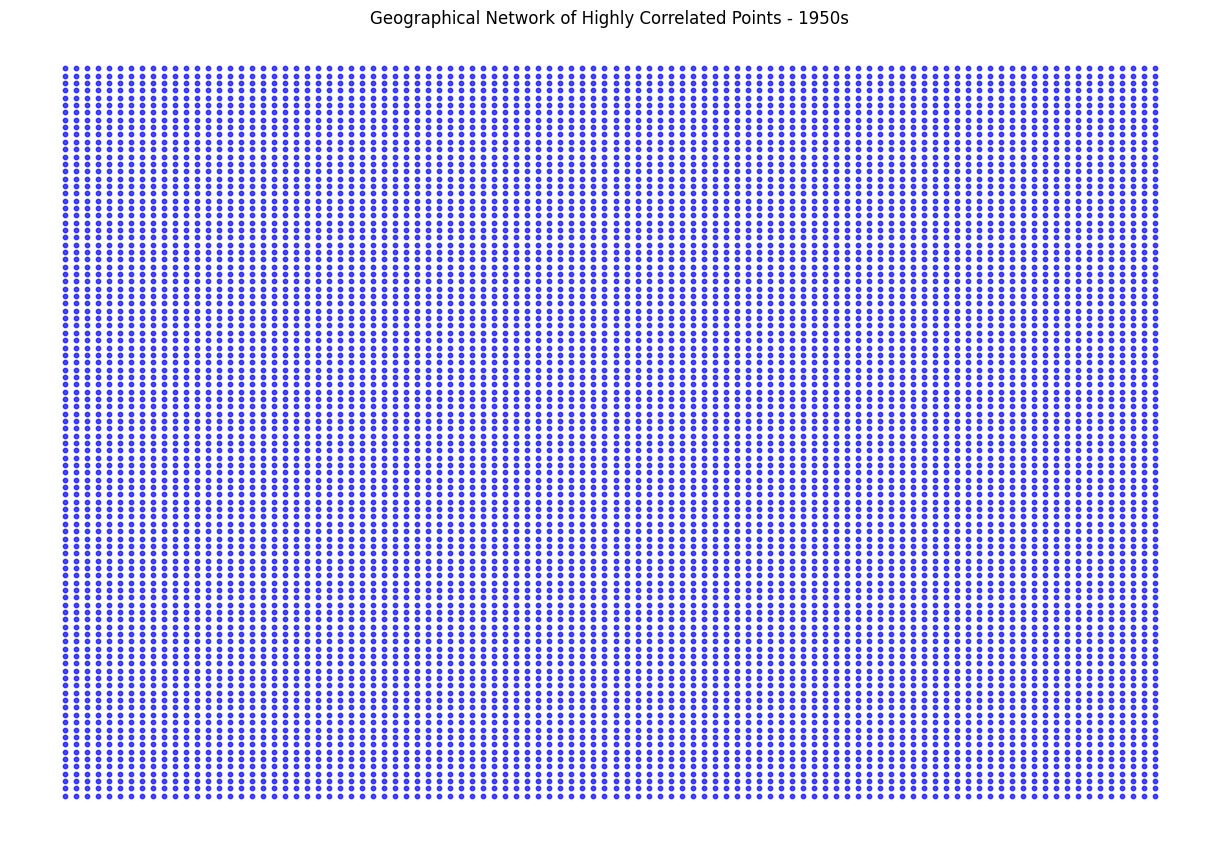

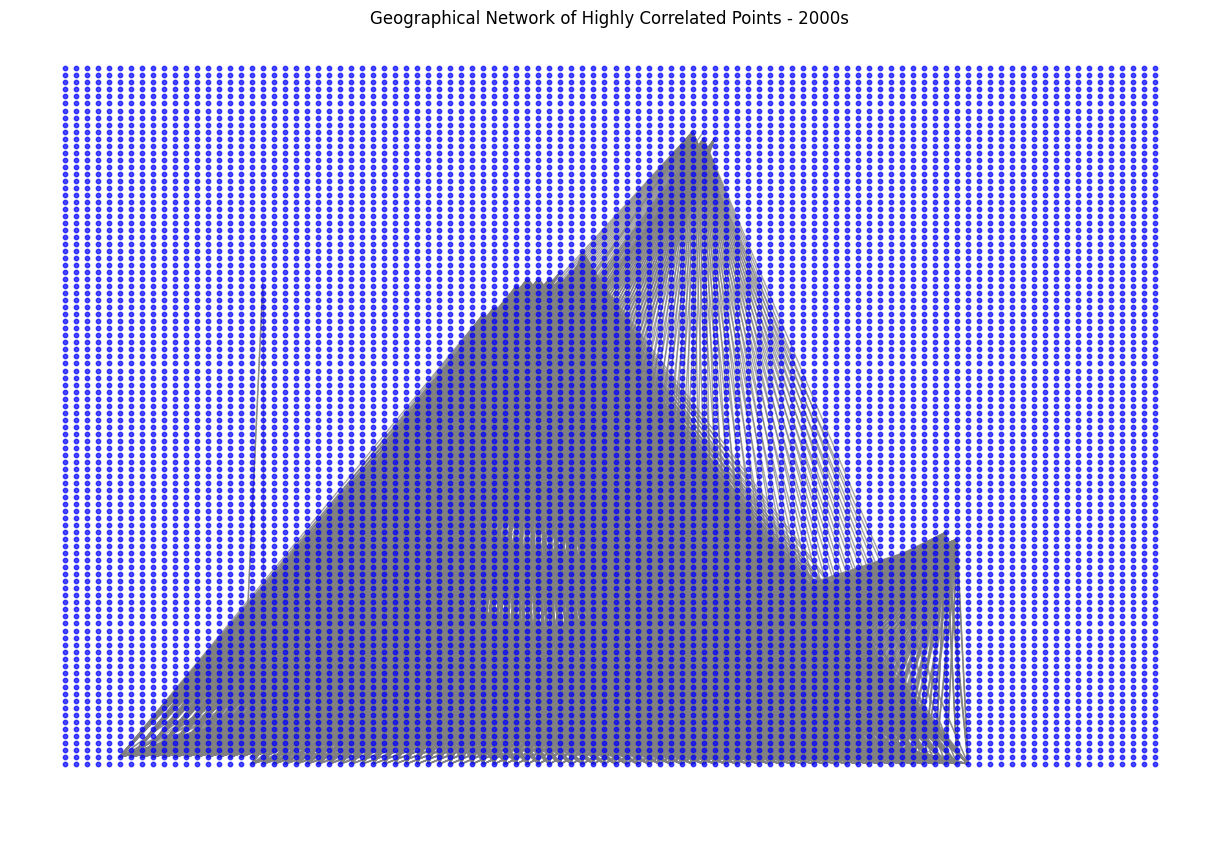

In [17]:
# Obtener las matrices de correlación específicas para las décadas de 1950 y 2000
# Aquí, "1950" y "2000" son los años de referencia para las respectivas décadas.
corr_matrix_1950 = correlation_matrices_by_decade[1950]
corr_matrix_2000 = correlation_matrices_by_decade[2000]

# Red para la década de 1950
create_and_plot_geographical_network(corr_matrix_1950, flat_latitudes, flat_longitudes, "Geographical Network of Highly Correlated Points - 1950s")

# Red para la década de 2000
create_and_plot_geographical_network(corr_matrix_2000, flat_latitudes, flat_longitudes, "Geographical Network of Highly Correlated Points - 2000s")

In [ ]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming 'data' is already loaded
times = data['time'].values

# Define the decades based on the time variable (assuming time is in years)
decades = np.floor(times / 10) * 10

# Initialize a dictionary to hold the correlation matrices by decade
correlation_matrices_by_decade = {}

# Process data by decade
unique_decades = np.unique(decades)

# Create a directory to save the data
save_dir = 'decade_correlations'
os.makedirs(save_dir, exist_ok=True)

for decade in unique_decades:
    # Extract data for the current decade
    decade_mask = (decades == decade)
    temperature_decade = temperature[decade_mask, :]

    # Interpolate the data onto a regular grid for all time points in the decade
    num_time_points_decade = temperature_decade.shape[0]
    temperature_grid_over_time_decade = np.empty((num_time_points_decade, 100, 100))

    for t in range(num_time_points_decade):
        temperature_grid_over_time_decade[t] = griddata(
            (latitudes, longitudes), 
            temperature_decade[t], 
            (lat_grid_mesh, lon_grid_mesh), 
            method='linear'
        )

    # Reshape the data for correlation calculation
    reshaped_temperature_data_decade = temperature_grid_over_time_decade.reshape(num_time_points_decade, -1)

    # Calculate the correlation matrix for this decade
    correlation_matrix_decade = np.corrcoef(reshaped_temperature_data_decade.T)
    
    # Store the correlation matrix in the dictionary
    correlation_matrices_by_decade[int(decade)] = correlation_matrix_decade

    # Save the correlation matrix for this decade
    np.save(os.path.join(save_dir, f'correlation_matrix_{int(decade)}.npy'), correlation_matrix_decade)

# Outputting the keys (decades) for confirmation
saved_decades = list(correlation_matrices_by_decade.keys())
print(f"Correlation matrices saved for decades: {saved_decades}")

# Save the list of decades
np.save(os.path.join(save_dir, 'saved_decades.npy'), np.array(saved_decades))

print(f"Data saved in directory: {save_dir}")